# Neural Network Classifier (BERT-Boosted) x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su Neural network per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda 'dataset_preprocessing.py')
2. Estrazione delle Features mediante BERT (si veda 'feature_extraction_bert_windows.ipynb'/'feature_extraction_bert_mac.ipynb')

In [12]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense,Reshape
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from keras.optimizers import Adam
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

All'interno del Notebook saranno addestrate due Reti Neurali, una sul Dataset "non-Lemmatizzato" e l'altra sul Dataset "Lemmatizzato".

In [13]:
# Verifica il dispositivo attualmente utilizzato da TensorFlow
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU disponibile, TensorFlow sta utilizzando la GPU.')
else:
    print('GPU non disponibile, TensorFlow sta utilizzando la CPU.')

GPU disponibile, TensorFlow sta utilizzando la GPU.


2024-02-11 17:50:07.553791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-11 17:50:07.553821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Funzioni di Supporto

In [3]:
# Pulizia della Frase
def clean_phrases(phrases):
    new_phrases = list()
    for phrase in phrases:
        # Rimozione di "\r" e "\n"
        phrase = re.sub(r'[\r\n]+', '', phrase)
        # Rimozione di sequenze di ":" (esempio, "::::")
        phrase = re.sub(r'::+', '', phrase)
        # Rimozione di sequenze di "=" (esempio, "====")
        phrase = re.sub(r'==+', '', phrase)
        # Rimozione di sequenze di "*" (esempio, "**")
        phrase = re.sub(r'\*\*+', '', phrase)
        # Rimozione di sequenze numeriche in formato di indirizzi IP (esempio, "192.168.1.1")
        phrase = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', phrase)
        # Rimozione di contenuto compreso tra Parentesi Quadre (esempio, "[contentContent]")
        phrase = re.sub(r'\[[^\[\]]+\]', '', phrase)
        # Rimozione di Apici, sia singoli che doppi
        phrase = re.sub(r"['\"]", "", phrase)

        ## La rimozione di particolari caratteri o sequenze di caratteri può portare alla fusione di due token diversi

        # Splitting di token in cui compare un segno di interpuzione forte ("?", "!" e ".") seguito da una lettera maiuscola
        phrase = re.sub(r'([?!\.])([A-Z]\w*)', r'\1 \2', phrase)
        # Splitting di parole fuse (esempio, "parolaParola" diventa "parola Parola")
        phrase = re.sub(r'([a-z])([A-Z])', r'\1 \2', phrase)

        tokens = word_tokenize(phrase)
        lowercase_tokens = [token.lower() for token in tokens if token.isalpha()]
        new_phrases.append(' '.join(lowercase_tokens))
    
    return new_phrases

In [4]:
# Carica il tokenizer e il modello preaddestrato di BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [5]:
# Definizione di una funzione per estrarre le caratteristiche di un testo utilizzando BERT
def extract_features(strings):
    # return_tensors ritorna il tensore per la versione pytorch
    # padding = true fa in modo che frasi di lunghezza diversa vengono portate alla lunghezza massima
    inputs = tokenizer(strings, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #rappresentazione media e unidimensionale delle caratteristiche estratte
    features = torch.mean(last_hidden_states, dim=1).squeeze()
    features = features.numpy()
    return pd.DataFrame(features)

# Neural Network

## Addestramento

In [14]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
print("Numero di Frasi nel Training Set:", len(training_set))
print("Numero Frasi 'toxic' nel Training Set:", len(training_set[training_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Training Set:", len(training_set[training_set['toxic'] == 0]))

Numero di Frasi nel Training Set: 15282
Numero Frasi 'toxic' nel Training Set: 3058
Numero Frasi 'not-toxic' nel Training Set: 12224


In [15]:
y_train = training_set['toxic']

In [16]:
X_train = pd.read_csv("./../../datasets/X_train_bert.csv")
print("X_train.shape", X_train.shape)

X_train.shape (15282, 768)


In [17]:
#CNN model Functional API
review = Input(shape=(X_train.shape[1],), dtype='float', name='review')
# Aggiunta di una dimensione per rappresentare il canale (l'input è bidimensionale e ci aspetta invece la dimensione associata al canale)
review_reshaped = Reshape((X_train.shape[1], 1))(review)
    
# Layer convoluzionali
conv_1 = Conv1D(filters=32, kernel_size=5, activation='relu')(review_reshaped)
max_pool_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(max_pool_1)
max_pool_2 = MaxPooling1D(pool_size=2)(conv_2)
conv_3 = Conv1D(filters=64, kernel_size=5, activation='relu')(max_pool_2)

# Appiattimento e strato fully-connected
flatten = Flatten()(conv_3)
main_output = Dense(1, activation='sigmoid', name='main_output')(flatten)

# Costruzione del modello
model = Model(inputs=[review], outputs=[main_output])
    
# Compilazione del modello
optimizer = Adam(lr=1e-2)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 review (InputLayer)         [(None, 768)]             0         
                                                                 
 reshape_2 (Reshape)         (None, 768, 1)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 764, 32)           192       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 382, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 380, 32)           3104      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 190, 32)           0         
 g1D)                                                      

In [9]:
#CNN model Sequential API
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train.shape[1],), dtype='float'),
        tf.keras.layers.Reshape((X_train.shape[1],1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ]
)

In [10]:
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 768, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 764, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 382, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 380, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 190, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 186, 64)           1

In [18]:
X_train = X_train.to_numpy()

# Addestramento sul Dataset non-lemmatizzato
print("Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...")
start = datetime.now()
model.fit(X_train, y_train,epochs=10, batch_size=32)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

model.save("neural_classifier_small.h5")

Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...
Epoch 1/10


2024-02-11 17:50:19.968522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-11 17:50:20.011710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


478/478 [==============================] - 14s 16ms/step - loss: 0.2486 - accuracy: 0.8976
Epoch 2/10
478/478 [==============================] - 5s 10ms/step - loss: 0.1892 - accuracy: 0.9216
Epoch 3/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1776 - accuracy: 0.9262
Epoch 4/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1670 - accuracy: 0.9301
Epoch 5/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1585 - accuracy: 0.9364
Epoch 6/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1488 - accuracy: 0.9403
Epoch 7/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1385 - accuracy: 0.9433
Epoch 8/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1307 - accuracy: 0.9478
Epoch 9/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1191 - accuracy: 0.9518
Epoch 10/10
478/478 [==============================] - 5s 11ms/step - loss: 0.1058 - accuracy: 0.9575

/Users/alessandropesare/anaconda3/envs/DL_GPU_Full/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
model = tf.keras.models.load_model("neural_classifier_small.h5")

## Testing

In [20]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)

test_set = test_data[test_data['toxic'] != -1]
exp_set = test_data[test_data['toxic'] == -1]

print("Numero di Frasi nel Test Set:", len(test_set))
print("Numero Frasi 'toxic' nel Test Set:", len(test_set[test_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Test Set:", len(test_set[test_set['toxic'] == 0]))

Numero di Frasi nel Test Set: 63842
Numero Frasi 'toxic' nel Test Set: 6087
Numero Frasi 'not-toxic' nel Test Set: 57755


In [21]:
X_test = pd.read_csv("./../../datasets/X_test_bert.csv")
print("X_test.shape:", X_test.shape)
y_test = test_set['toxic']

X_test.shape: (63842, 768)


In [22]:
i = 0
predictions = list()
while i < X_test.shape[0]:
    to_submit = X_test[i:i+2500]
    to_test = to_submit.to_numpy()
    y_pred = model.predict(to_test)
    predictions.append(y_pred)
    i += 2500

    del to_submit
    del to_test
    del y_pred

42/42 [==============================] - 1s 15ms/step


In [23]:
y_pred = np.concatenate(predictions)
y_pred.shape
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

In [24]:
#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred_binary)))
print("Precision: " + str(precision_score(y_test, y_pred_binary)))
print("Recall: " + str(recall_score(y_test, y_pred_binary)))
print("F-Measure: " + str(f1_score(y_test, y_pred_binary)))

Accuracy: 0.9110773472009023
Precision: 0.524866569626395
Recall: 0.7108592081485132
F-Measure: 0.6038657455864909


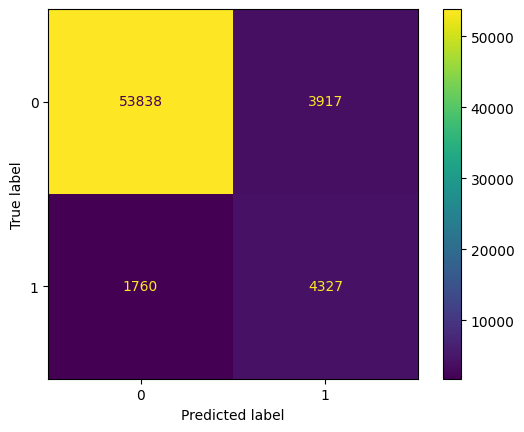

In [25]:
cm = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

## Generazione delle Explanations

In [18]:
# Utilizzare exp_set -> da vettorizzare con 'vectorizer' e sottoporre a 'cl'
# Implementare LIME